Remaining dataset size: (52681, 3)
Confusion Matrix:
[[ 628   18   24   17   15   46    7]
 [  17  423   36   11   15   17    8]
 [  96   57 1913  103   53   77  717]
 [  79   13   50 2899   18  114  135]
 [  10    4   18   12  169   19    5]
 [  59   13   35   25   23  370   11]
 [  12    7  432   72    3   21 1611]]

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.70      0.83      0.76       755
             Bipolar       0.79      0.80      0.80       527
          Depression       0.76      0.63      0.69      3016
              Normal       0.92      0.88      0.90      3308
Personality disorder       0.57      0.71      0.63       237
              Stress       0.56      0.69      0.62       536
            Suicidal       0.65      0.75      0.69      2158

            accuracy                           0.76     10537
           macro avg       0.71      0.76      0.73     10537
        weighted avg       0.77   

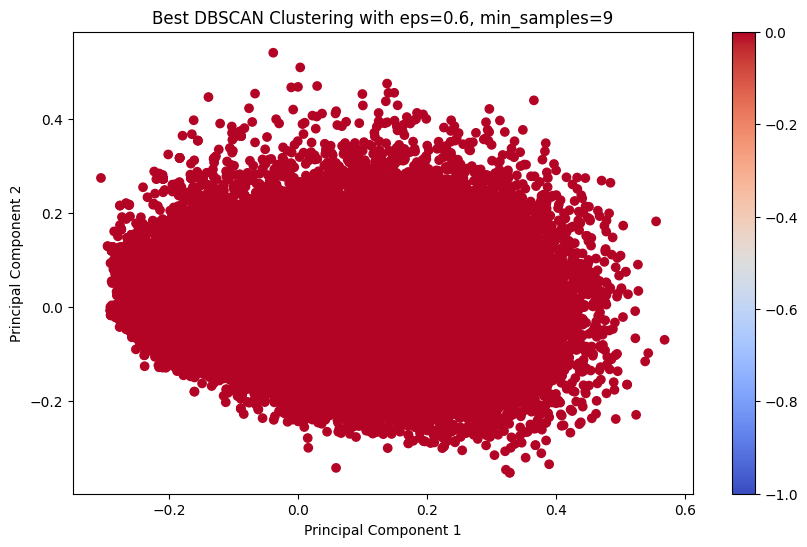

In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('Combined Data.csv')
data.head()

# Check and clean missing values
data = data.dropna(subset=['statement'])
print(f"Remaining dataset size: {data.shape}")

# Simple text cleaning function
def clean_text(text):
    # Remove special characters from the text
    text = re.sub(r'\W', ' ', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the text cleaning function to the 'statement' column
data['cleaned_statement'] = data['statement'].apply(clean_text)

# TF-IDF vectorization - Convert the text into numerical values
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['cleaned_statement']).toarray()

# ----- Supervised Learning: Logistic Regression with SMOTE -----
# Target variable (status) for supervised learning
y = data['status']

# Split the data into training and test sets for supervised learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Logistic Regression model after SMOTE
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the Logistic Regression model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ----- Unsupervised Learning: DBSCAN with best parameters -----

# PCA for dimensionality reduction (optional but useful for high-dimensional data)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Apply DBSCAN with best parameters (eps=0.6, min_samples=9)
dbscan = DBSCAN(eps=0.6, min_samples=9)
dbscan_clusters = dbscan.fit_predict(X_pca)

# Evaluate DBSCAN with Silhouette Score
if len(set(dbscan_clusters)) > 1:  # Silhouette score needs more than 1 cluster
    dbscan_silhouette = silhouette_score(X_pca, dbscan_clusters)
    print(f"DBSCAN Silhouette Score (best parameters): {dbscan_silhouette:.4f}")
else:
    print("DBSCAN produced only one cluster or noise, unable to calculate Silhouette Score.")

# Visualizing DBSCAN Clustering using PCA-reduced data
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_clusters, cmap='coolwarm', marker='o')
plt.title(f'Best DBSCAN Clustering with eps=0.6, min_samples=9')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()
